In [12]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report 

In [13]:
data = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)

In [14]:
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [15]:
data.info() 
# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


# **Preprocessing**

In [16]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    #transform headlines to sequence arrays
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train:
        # Calculate max lenght of the array
        max_seq_length = np.max(list(map(len,sequences)))
    
    #padding sequences up to max len
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences
    

In [17]:
def preprocess_input(df):
    df = df.copy()
    
#     drop feature
    df.drop('article_link', axis=1)
    
#  X and y variables    
    X = df['headline']
    y = df['is_sarcastic']

#     split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=1)
    
#     create and fit tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train)
    
    print("Vocab length", len(tokenizer.word_index) + 1)
    
#     get sequence data
    X_train = get_sequences(texts=X_train, tokenizer=tokenizer, train=True)
    X_test = get_sequences(texts=X_test, tokenizer=tokenizer, train=False, max_seq_length = X_train.shape[1])

    print("Sequence Length", X_train.shape[1])
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = preprocess_input(data)

Vocab length 24846
Sequence Length 40


In [19]:
X_train

array([[ 3579,   481,  1858, ...,     0,     0,     0],
       [ 6496,  4001,     7, ...,     0,     0,     0],
       [ 8490,   343,    11, ...,     0,     0,     0],
       ...,
       [ 4518,  2106, 24841, ...,     0,     0,     0],
       [24843,  1042,  1441, ...,     0,     0,     0],
       [   24,     1,  5280, ...,     0,     0,     0]], dtype=int32)

In [20]:
y_train.value_counts()

is_sarcastic
0    10499
1     8197
Name: count, dtype: int64

# Training

In [22]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim = 24846, #Vocab length
    output_dim = 64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[
                 'accuracy',
                 tf.keras.metrics.AUC(name='auc')
             ]
             )

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 40, 64)         │     1,590,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,934,593 (7.38 MB)

 Trainable params: 1,934,593 (7.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size = 32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
        )
    ]
)

Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7045 - auc: 0.7801 - loss: 0.5192 - val_accuracy: 0.8535 - val_auc: 0.9368 - val_loss: 0.3303
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9673 - auc: 0.9937 - loss: 0.0943 - val_accuracy: 0.8457 - val_auc: 0.9219 - val_loss: 0.4201
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9986 - auc: 0.9999 - loss: 0.0077 - val_accuracy: 0.8535 - val_auc: 0.9105 - val_loss: 0.6176
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9995 - auc: 1.0000 - loss: 0.0019 - val_accuracy: 0.8524 - val_auc: 0.9059 - val_loss: 0.7081


# Results

Accuracy: 85.80%
AUC: 0.93981
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


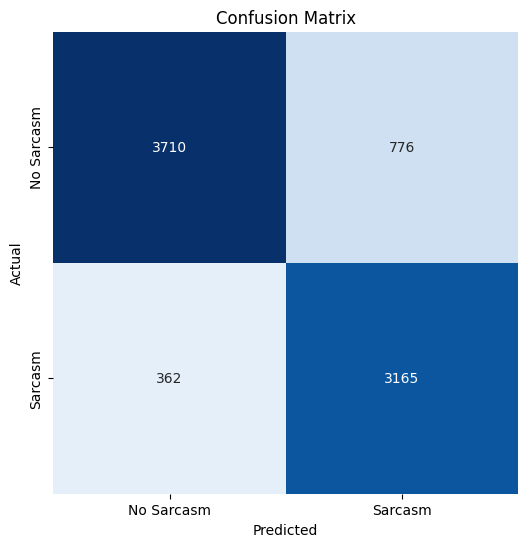

Classification Report
....................
               precision    recall  f1-score   support

  No Sarcasm       0.91      0.83      0.87      4486
     Sarcasm       0.80      0.90      0.85      3527

    accuracy                           0.86      8013
   macro avg       0.86      0.86      0.86      8013
weighted avg       0.86      0.86      0.86      8013



In [31]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: {:.2f}%".format(results[1]*100))
print("AUC: {:.5f}".format(results[2]))

y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
clr = classification_report(y_test, y_pred, labels=[0,1], target_names=["No Sarcasm", "Sarcasm"])

plt.figure(figsize=[6,6])
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report\n....................\n",clr)

In [32]:
y_pred

array([1, 0, 0, ..., 1, 0, 0])